In [2]:
import pgmpy

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
cars_data = pd.read_csv('data/car.data', names=["Buying", "Maintenance", "Doors", "People", "LugBoot", "Safety", "Acceptability"])
cars_data

,Buying,Maintenance,Doors,People,LugBoot,Safety,Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [5]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

hc = HillClimbSearch(cars_data, scoring_method=BicScore(cars_data))
best_model = hc.estimate()
print(best_model.edges())

  0%|          | 9/1000000 [00:00<14:32:39, 19.10it/s]


[('Buying', 'Maintenance'), ('Safety', 'People'), ('Safety', 'LugBoot'), ('Acceptability', 'Safety'), ('Acceptability', 'People'), ('Acceptability', 'Buying'), ('Acceptability', 'Maintenance'), ('Acceptability', 'LugBoot')]


In [6]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

bayesian_model = BayesianModel(best_model.edges())
bayesian_model.fit(cars_data, estimator=MaximumLikelihoodEstimator)
for cpd in bayesian_model.get_cpds():
    print(cpd)

+----------------------+-----------+
| Acceptability(acc)   | 0.222222  |
+----------------------+-----------+
| Acceptability(good)  | 0.0399306 |
+----------------------+-----------+
| Acceptability(unacc) | 0.700231  |
+----------------------+-----------+
| Acceptability(vgood) | 0.0376157 |
+----------------------+-----------+
+---------------+---------------------+---------------------+----------------------+----------------------+
| Acceptability | Acceptability(acc)  | Acceptability(good) | Acceptability(unacc) | Acceptability(vgood) |
+---------------+---------------------+---------------------+----------------------+----------------------+
| Buying(high)  | 0.28125             | 0.0                 | 0.26776859504132233  | 0.0                  |
+---------------+---------------------+---------------------+----------------------+----------------------+
| Buying(low)   | 0.23177083333333334 | 0.6666666666666666  | 0.21322314049586777  | 0.6                  |
+---------------+--

In [7]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(bayesian_model)

Now, it would be interesting to answer some questions:
* Is maintenance harder for 2-seaters than for family cars?

In [8]:
print(exact_inference.query(["Maintenance"],{'People':"2"}))
print(exact_inference.query(["Maintenance"],{'People':"4"}))



Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 500.93it/s]

Eliminating: Acceptability: 100%|██████████| 4/4 [00:00<00:00, 482.56it/s]


+--------------------+--------------------+
| Maintenance        |   phi(Maintenance) |
+====================+====================+
| Maintenance(high)  |             0.2595 |
+--------------------+--------------------+
| Maintenance(low)   |             0.2215 |
+--------------------+--------------------+
| Maintenance(med)   |             0.2215 |
+--------------------+--------------------+
| Maintenance(vhigh) |             0.2975 |
+--------------------+--------------------+
+--------------------+--------------------+
| Maintenance        |   phi(Maintenance) |
+====================+====================+
| Maintenance(high)  |             0.2450 |
+--------------------+--------------------+
| Maintenance(low)   |             0.2648 |
+--------------------+--------------------+
| Maintenance(med)   |             0.2646 |
+--------------------+--------------------+
| Maintenance(vhigh) |             0.2256 |
+--------------------+--------------------+


It looks like it is, indeed. Then,
* Are cars with high maintenance safer?

In [9]:
print(exact_inference.query(["Safety"],{'Maintenance':"vhigh"}))


Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: LugBoot:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: People:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Buying:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Acceptability: 100%|██████████| 4/4 [00:00<00:00, 425.22it/s]


+--------------+---------------+
| Safety       |   phi(Safety) |
+==============+===============+
| Safety(high) |        0.2793 |
+--------------+---------------+
| Safety(low)  |        0.3967 |
+--------------+---------------+
| Safety(med)  |        0.3240 |
+--------------+---------------+


Looks like they're not. 
* Is the lugboot involved in safety?

In [10]:
print(exact_inference.query(["LugBoot"],{'Safety':"low"}))



  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


Eliminating: Maintenance:   0%|          | 0/4 [00:00<?, ?it/s]


Eliminating: People:   0%|          | 0/4 [00:00<?, ?it/s]     


Eliminating: Buying:   0%|          | 0/4 [00:00<?, ?it/s]


Eliminating: Acceptability: 100%|██████████| 4/4 [00:00<00:00, 514.80it/s]


+----------------+----------------+
| LugBoot        |   phi(LugBoot) |
+================+================+
| LugBoot(big)   |         0.3333 |
+----------------+----------------+
| LugBoot(med)   |         0.3333 |
+----------------+----------------+
| LugBoot(small) |         0.3333 |
+----------------+----------------+


## Approximate inference
We'd now like to try and infer probabilities from samples, by extracting $n$ samples from the distribution and calculating the probability.
According to **Hoeffding’s inequality**, we know that
$$
P(|s-p|>\epsilon) \le 2 e^{-2n\epsilon^2}
$$
which we can use to get a desired number of samples to extract.
We'll try two different techniques, **Rejection Sampling** and **Likelihood weighting**. 
The first estimates the probability by counting the samples that are consistent with the evidence, and it is a process similar to what we do in the real world.
The latter, instead, only samples nonevidence variables, then weights them by the likelihood they accord the evidence.

In [38]:
class SampleTester():
    def __init__(self, bayesian_model):
        self.bayesian_model = bayesian_model
        self.sampler = BayesianModelSampling(bayesian_model)
        self.exact_inference = VariableElimination(bayesian_model)
    def test_sample_methods(self, evidence, query, sample_size_min = 100, sample_size_max=10**5, num_of_experiments=20):
        test_range = range(sample_size_min, sample_size_max, int((sample_size_max-sample_size_min)/num_of_experiments))
        errors_lws = []
        errors_rs = []
        exact_result = self.exact_inference.query([query], dict(evidence), show_progress=False).values
        for size in test_range:
            lws_probs = self.process_lws(size, evidence, query)
            rs_probs = self.process_rs(size, evidence, query)
            lws_error = self.absolute_error(lws_probs, exact_result)
            rs_error = self.absolute_error(rs_probs, exact_result)
            print(f"🎲 Experiment of size {size} achieved mean error {np.average(lws_error)} with LWS and {np.average(rs_error)} with RS 🎲")
            errors_lws.append(lws_error)
            errors_rs.append(rs_error)
        return list(test_range), errors_lws, errors_rs
    def process_lws(self, size, evidence, query):
        likelihood_sample = self.sampler.likelihood_weighted_sample(evidence=evidence, size=size, return_type='recarray') # The show_progress is part of commit #bda1004 and hasn't been published on PyPi yet
        sample_probs = self.return_weighted_probs(likelihood_sample[query],likelihood_sample['_weight'])
        return sample_probs
    def process_rs(self, size, evidence, query):
        rejection_sample = self.sampler.rejection_sample(evidence=evidence, size=size, return_type='recarray', show_progress=False)[query]
        sample_probs = self.return_probs(rejection_sample)
        return sample_probs
    def absolute_error(self, sample_probs, exact_probs):
        absolute_error = np.fromiter(sample_probs.values(), dtype=float) - np.array(exact_probs)
        return absolute_error
    def return_probs(self, samples):
        unique, counts = np.unique(samples, return_counts=True) # Get the unique values and their counts
        counts = (counts/len(samples))# Divide the counts by the total number, getting a probability from 0 to 1
        return dict(zip(unique, counts)) # Zip the value and its probability in a dict
    def return_weighted_probs(self, samples, weights):
        unique = np.unique(samples)
        counts = np.zeros(len(np.unique(samples))) # We fill a zero array for the weights sum, the  we'll divide it by the sum of weights
        iterator = np.nditer(samples, flags=['f_index'])
        for value in iterator:
            counts[value] += weights[iterator.index]
        counts = (counts/np.sum(weights))
        return dict(zip(unique, counts)) # Zip the value and its probability in a dict


from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State


evidence = [State('Safety', 'high'),State('Maintenance', 'low')]

st = SampleTester(bayesian_model)
i, errors_lws, errors_rs = st.test_sample_methods(evidence, "Acceptability")

/opt/anaconda3/envs/bncars/lib/python3.8/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:518: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(
Generating for node: People: 100%|██████████| 6/6 [00:19<00:00,  3.32s/it]     


🎲 Experiment of size 100 achieved mean error -8.326672684688674e-17 with LWS and -3.122502256758253e-17 with RS 🎲
🎲 Experiment of size 5095 achieved mean error -1.609823385706477e-15 with LWS and -3.469446951953614e-17 with RS 🎲
🎲 Experiment of size 10090 achieved mean error -3.2057689836051395e-15 with LWS and -2.7755575615628914e-17 with RS 🎲
🎲 Experiment of size 15085 achieved mean error -4.253541963095131e-15 with LWS and -2.7755575615628914e-17 with RS 🎲
🎲 Experiment of size 20080 achieved mean error -8.6389229103645e-15 with LWS and -2.0816681711721685e-17 with RS 🎲
🎲 Experiment of size 25075 achieved mean error -1.1594891713428979e-14 with LWS and -1.3877787807814457e-17 with RS 🎲
🎲 Experiment of size 30070 achieved mean error -1.1844691893969639e-14 with LWS and -2.0816681711721685e-17 with RS 🎲
🎲 Experiment of size 35065 achieved mean error -9.145462165349727e-15 with LWS and -3.469446951953614e-17 with RS 🎲
🎲 Experiment of size 40060 achieved mean error -5.447031714567174e-15

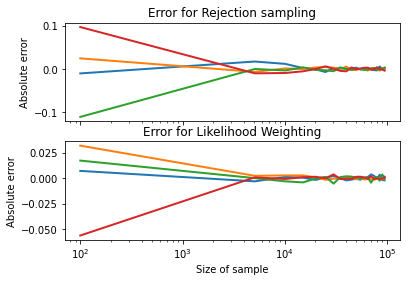

In [39]:
def plot_graphs(sizes, errors_lws, errors_rs):
    fig, axs = plt.subplots(2, sharex=True)
    line = axs[0].semilogx(i, errors_lws, lw=2)
    line2 = axs[1].semilogx(i, errors_rs, lw=2)
    axs[0].title.set_text("Error for Rejection sampling")
    axs[1].title.set_text("Error for Likelihood Weighting")
    axs[1].set_xlabel("Size of sample")
    for ax in axs:
        ax.set_ylabel("Absolute error")
    plt.show()
plot_graphs(i, errors_lws, errors_rs)

